https://blog.csdn.net/weixin_42001089/article/details/85343332

## 直方图 FeatureHistogram

在训练树的时候，需要找到最佳划分节点，为此其中需要遍历特征下的每一个value，  
这里通常有两种做法：pre-sorted algorithm(预排序算法)和histogram-based algorithm（直方图算法）。

预排序算法就是传统的要遍历当前特征下的每一个value，其通常是在开始对该特征下的每个value进行排序，后面就是遍历选取最佳划分点  
直方图算法其实就是将value离散化了，生成一个个bin，常称为分桶，离散化后的bin数其实是小于原始的value数的，于是复杂度从（#feature*#data）降为了（#feature*#bin）。

需要注意：直方图算法并不是LightGBM所特有的或是闪亮点（其闪亮点还是论文所说的两大技术GOSS和EFB），  
GBDT的相关演变算法有很多，有部分计算法就用了直方图，类如Scikit-learn和gbm in R演变算法使用了pre-sorted algorithm算法，  
pGBRT算法是使用了histogram-based algorithm，而XGBoost两者都支持，
这里多说一句，Xgboost的近似算法其实就用了histogram-based algorithm(分位数或者近似分位数作为划分点)

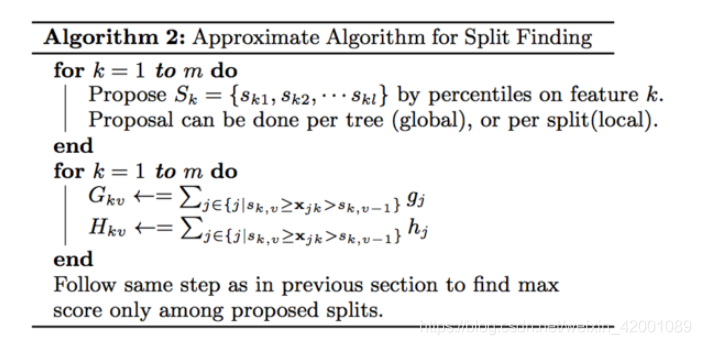

对于特征k这里找到先找到一组候选分割点就是上图中的Sk1,Sk2,Sk2,这里和LightGBM中所提到的bin其实思想是一样的

不同于pre-sorted algorithm的穷举方法，这里有两种算法一种是全局算法：即在初始化tree的时候划分好候选分割点，并且在树的每一层都使用这些候选分割点；另一种是局部算法，即每一次划分的时候都重新计算候选分割点。这两者各有利弊，全局算法不需要多次计算候选节点，但需要一次获取较多的候选节点供后续树生长使用，而局部算法一次获取的候选节点较少，可以在分支过程中不断改善，即适用于生长更深的树，两者在effect和accuracy做trade off。

关于怎么找这些候选集合，其使用了Weighted Quantile Sketch算法，有兴趣的同学可以看一下： 
  
https://blog.csdn.net/anshuai_aw1/article/details/83025168

总结：
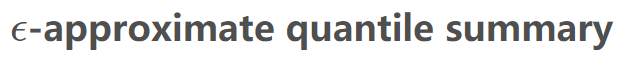
大致来讲下思路：ϵ \epsilonϵ-approximate quantile summary这个数据结构不需要一次存入所有的数据，它先用一些元组存入部分数据（当然在内部需要排序），这些元组记录的是现有的value值和一些位置信息，有了这些信息，就保证了能够以 εN的精度计算任意的分位查询。只要流式系统中每个时刻都维持这种summary结构，每次查询都能满足精度要求，但是流式数据实时更新，需要解决新增数据的summary更新问题。为此，算法提供了insert操作，insert操作可以保证现有的summary结构仍然可以保证 εN的精度。当然，每次数据插入都需要新增元组，summary结构不能持续增加而不删除，因此到达一定程度需要对summary进行delete。同时，delete操作也可以保证现有的summary结构仍然可以保证 εN的精度。
其实整个算法比较复杂，详见参考文献【1】【4】。建议认真阅读【1】。

到这里，我们已经知道，有了ϵ approximate quantile summary这个数据结构，无论多大的数据，我们只要给定查询的rank值，就可以得到误差在 εN以内的近似分位点。

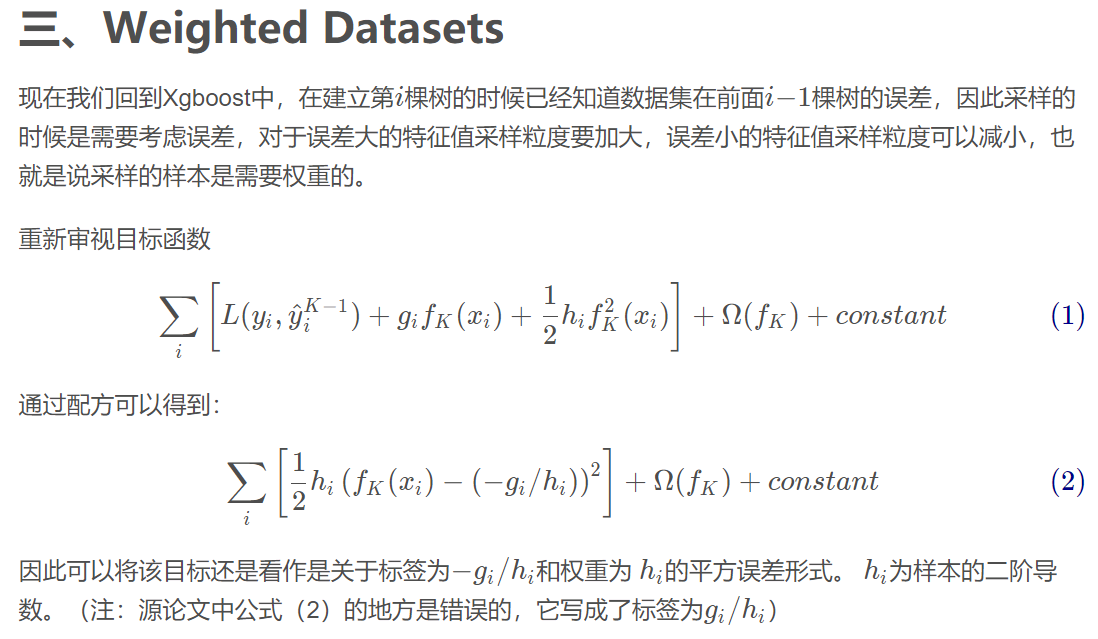

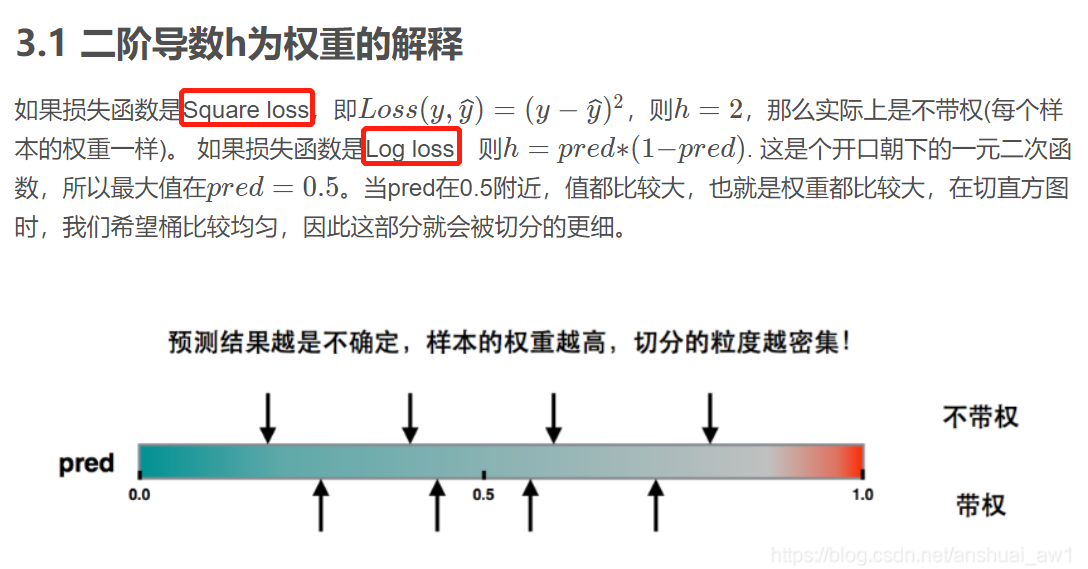

以上都是基于XGBoost改良版本的方法

下面我们正式来看下LightGBM的直方图源码：  
位于LightGBM/src/treelearner/feature_histogram.hpp  
其下一共有三个类：  
FeatureMetainfo  
FeatureHistogram  
HistogramPool  

其中 FeatureMetainfo类是直方图分裂算法的一些基本配置，其只有属性没有方法。  
FeatureHistogram可以说是直方图分裂算法的核心部分，我们主要来看看该类和分裂相关的几个主要方法，其属性很简单就是data_即直方图中的储存数据，包括  一阶导数总和以及二阶导数总和等等。  
HistogramPool类的作用就是构建data_的过程。  

直方图寻找最佳切分点  
首先其可以看成是两大类：  
一：特征下的值是非连续的即所谓的类别特征。  
二：特征下的值是连续的  

## FindBestThresholdCategorical：处理处理类别特征。  
其分为两种情况：one-hot形式和非one-hot形式  
one-hot形式其实是一种one VS many的情况，而非one-hot是一种many VS many形式
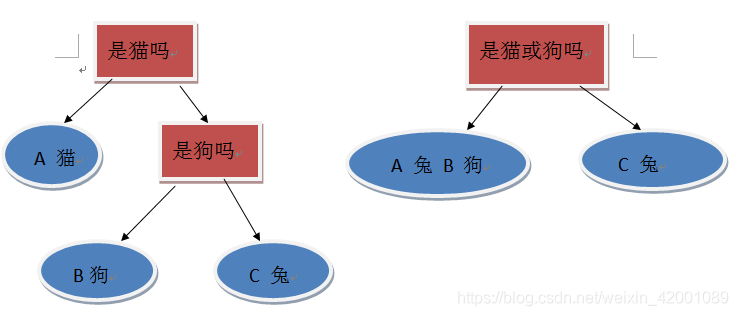
那么不言而喻第二种在大数据的情况下，好处多多，起码考虑的情况更多，而且不至于树深度太大，还有一个直观的好处就是单一的分裂其实带来的增益通常较少，因为每次仅仅从一大推信息中区分出那么一丁点信息，带来的信息增益自然不会高，第二种则是不一样。

加下来我们具体看看源码：

当bin的数目小于meta_->config->max_cat_to_onehot时即类别数目较少时例如开关状态只有两种这时候就采用one-hot形式，否则不采用one-hot形式。

当采用one-hot形式时：遍历每一个bin（类别），丢弃那些样本少的类别以及总二阶导数和少的样本：

In [ ]:
if (use_onehot) {
      for (int t = 0; t < used_bin; ++t) {
        // if data not enough, or sum hessian too small
        if (data_[t].cnt < meta_->config->min_data_in_leaf
            || data_[t].sum_hessians < meta_->config->min_sum_hessian_in_leaf) continue;
        data_size_t other_count = num_data - data_[t].cnt;
        // if data not enough
        if (other_count < meta_->config->min_data_in_leaf) continue;
 
        double sum_other_hessian = sum_hessian - data_[t].sum_hessians - kEpsilon;
        // if sum hessian too small
        if (sum_other_hessian < meta_->config->min_sum_hessian_in_leaf) continue;


注意看：这里是综合考虑左右子树的即只要按当前的bin划分出来的左右子树有一个满足抛弃条件即抛弃。同时这里也很好的体现了所谓的直方图差加速概念，说白了就是我们只要得到比如左子树，那么右子树就直接可以使用总的减去左子树得到，是不是很快！是不是很巧妙！这就是差加速的概念。

从这里可以看到ont-hot的one VS many形式：因为 不论是other_count还是sum_other_hessian等等都是除了当前这一类别之外其他所有类别的和。

最少样本数和最少二阶导数和树均是配置参数：meta_->config->min_data_in_leaf，config->min_sum_hessian_in_leaf

然后在剩下的bin中使用GetSplitGains计算得到分裂后的左右子树的熵的和current_gain，其先和min_gain_shift比较，

 if (current_gain <= min_gain_shift) continue;
min_gain_shift是最小熵其定义如下：

min_gain_shift = gain_shift + meta_->config->min_gain_to_split
其中gain_shift是通过GetLeafSplitGain计算得到的未分裂前的熵，min_gain_to_split是一个配置参数，其含义就是当前分裂最小需要的增益。话句话说比如没有分裂前熵是5，我们要求分裂后熵最少的增加2，所以当current_gain小于等于7时，说明利用该Bin分裂得到的增益不大，就不选用该bin作为分裂节点了，直接跳过。更直接点说就是分裂了还没有没分裂前熵大，那还分什么，对吧。

当不采用one-hot形式时：  
其首先遍历bin，得到样本多的bin，这一结果保存在sorted_idx中；  
然后对sorted_idx根据（一阶导数/(二阶导数+meta_->config->cat_smooth)）的大小进行排序：

接下来是两个for循环，外面for循环代表的是方向即从左到右和从右到左两种遍历方式，为了便于理解这里举一个简单的例子，假设当前这一特征有4种类别：A,B,C,D,数学化后为0,1,2,3

那么我们先按照从左到右的顺序遍历，从0开始那么左树类别就是0，右树就是1,2,3,4计算增益比较更新，接着到1，那么左树就是0和1，右树就是2,3,4计算增益比较更新,接着到2，那么左树就是0,1,2右树就是3

这里需要两点说明：

<1>可以看到非one-hot 是一种many VS many的形式即有左子树是0和1，右子树是2,3这种情况，而在one-hot中是不会出现这种情况的，其只可能是左子树是0，右子树是1,2,3或左子树是1，右子树是0,2,3这种one VS many的形式。  
<2>左右两次遍历的意义何在？其意义就在于缺省值到底是在哪里？其实这类问题叫做Sparsity-aware Split Finding稀疏感知算法  

当从左到右，对于缺省值就规划到了右面，当方向相反时，缺省值都规划到了左面，大家可以这样想这个问题：

当从左到右时，我们记录不论是当前一阶导数和也好二阶导数也罢，都是针对有值的（缺省值就没有一阶导数和二阶导数），那么我们用差加速得到右子树，既然左子树没有包括缺省值，那么总的减去左子树自然就将缺省值归到右子树了，假如没有缺省值，其实这里进行两次方向的遍历并没有什么意义，为什么呢？假如最好的划分是样本1和样本3在一边，样本2和样本4在一边，那么两次方向遍历无非就是对应下图两种情况：

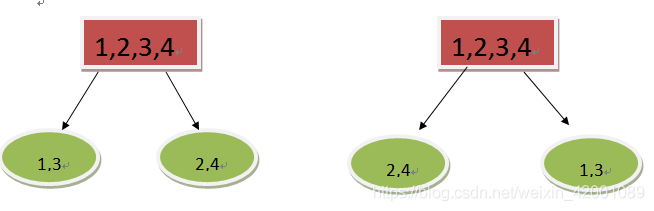

有区别吗？其实并没有，因为下一次根据Leaf-wise原则无非就是选取左面和右面一个进行下去即可所以说1,3到底在左面还是右面并没有关系  
可是当有缺省值时就完全不一样了

## FindBestThresholdNumerical：处理连续特征

In [ ]:
FindBestThresholdSequence：处理连续特征的分裂算法核心
 double current_gain = GetSplitGains(sum_left_gradient, sum_left_hessian, sum_right_gradient, sum_right_hessian,
                                            meta_->config->lambda_l1, meta_->config->lambda_l2, meta_->config->max_delta_step,
                                            min_constraint, max_constraint, meta_->monotone_type);
        // gain with split is worse than without split
        if (current_gain <= min_gain_shift) continue;
 
        // mark to is splittable
        is_splittable_ = true;
        // better split point
        if (current_gain > best_gain) {
          best_left_count = left_count;
          best_sum_left_gradient = sum_left_gradient;
          best_sum_left_hessian = sum_left_hessian;
          // left is <= threshold, right is > threshold.  so this is t-1
          best_threshold = static_cast<uint32_t>(t - 1 + bias);
          best_gain = current_gain;
        }

可以看到和处理类别特征非one-hot形式一样，方向的话这里就简单判断了一下：是-1时从右遍历，1是从左：

LightGBM分箱算法  
LightGBM使用的分箱方法克服了以上所有缺点，在此推荐一下。主要特点如下：  
1、由于数据集中经常会出现零值，所以零值单独使用一个箱子。  
2、相同特征值的数据一定在一个箱子中。  
3、采用动态平衡机制，各个箱子中的数据量基本一致。  
所以，lightgmb的分箱方法可以看作是一个等频分箱的方法，但是采用了动态平衡机制，各个箱子的数据量基本相同但又不完全相同，克服了传统等频分箱的缺点。  
代码可参考：  
https://blog.csdn.net/yftadyz/article/details/108466687

接着说一下HistogramPool这个类：
说白了该类主要就是构建data_的信息，其中包括bin等等，深入到代码中你会发现其主要是使用了Dataset这个数据集，例如下面的train_data：

In [ ]:
void DynamicChangeSize(const Dataset* train_data, const Config* config, int cache_size, int total_size) {
    if (feature_metas_.empty()) {
      int num_feature = train_data->num_features();
      feature_metas_.resize(num_feature);

In [ ]:
而这个Dataset类是在通过头文件中导入的：

#include <LightGBM/dataset.h>
于是可以找到对应的源代码，仔细看其细节：

该类具体在LightGBM/include/LightGBM/dataset.h，大约在282行就可以看到其定义，这是头文件，其只是定义了一些接口，其主要实现细节即.cpp是在LightGBM/src/io/dataset.cpp位置。
该类有很多属性和方法，其中比较重要的方法就是：ConstructHistograms方法即构造直方图方法

从该方法中可以看到很多细节，例如使不使用二阶导数，不使用时会将其视为一个常数：

In [ ]:
if (!is_constant_hessian) {
      #pragma omp parallel for schedule(static)
      for (data_size_t i = 0; i < num_data; ++i) {
        ordered_gradients[i] = gradients[data_indices[i]];
        ordered_hessians[i] = hessians[data_indices[i]];
      }
    } else {
      #pragma omp parallel for schedule(static)
      for (data_size_t i = 0; i < num_data; ++i) {
        ordered_gradients[i] = gradients[data_indices[i]];
      }
    }

In [ ]:
这里的data_indices[i]就是具体到每一个样本，可以看到，当不使用二阶导数时即else部分就没有记录具体每个样本的二阶导数。但一阶导数都是始终记录的。

## 说到这里我们有必要另外起一个分界线了：因为下面涉及到LightGBM论文中提到的两大技术之一：EFB

EFB
上述我们已经简单介绍过了，在原论文中给出特征捆绑算法：
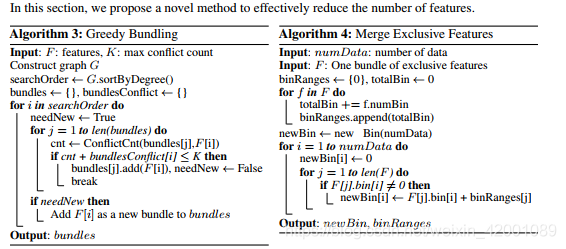

大部分高纬度的数据集都是稀疏的，这就为我们捆绑特征带来了可能性，特征的稀疏就说明很多特征是相互排斥的，例如它们不总是同时取非0值，所以我们可以很放心的将多个特征捆绑为一个特征，所以复杂度就从（#data*#feature）降为（#data*#bundle）,其中bundle就是经过捆绑后的特征数，通常bundle远小于feature。

需要点（论文2.2第三段）：这和以往减少特征有着很大的区别，以往采用的都是例如PCA这种，但是这种算法有一个大前提那就是

特征有冗余性比如：动物类别，是否是狗（是笔者自己举的例子），很明显两个特征其实有冗余性，但是这种情况并不是出现，当特征没有这种冗余性的时候，这种算法就逊色很多了，于是LightGBM在特征降维这个问题上，提出了EFB来解决这一棘手问题。

到此就面临到两个待解决的问题：（1）到底那些特征需要合并到一起（2）怎么合并到一起

其中（1）是采用图涂色算法，同时注意到有些特征并不是100%的互相排斥，但是呢？其也很少同时取非0值，如果我们允许一部分冲突，那么这部分特征就可以进一步进行合并，使得bundle进一步减少。

说了这么多可能大家还是一头雾水，相互排斥到底是个什么东西？下面就一种理想情况画一张图直观的看一下其原理：

假设现在有13个样本，每个样本有四个特征A,B,C,D,可以看到这很稀疏了吧（左图），那么怎么合并呢？很简单将ABCD捆绑为一个特征M就是右图
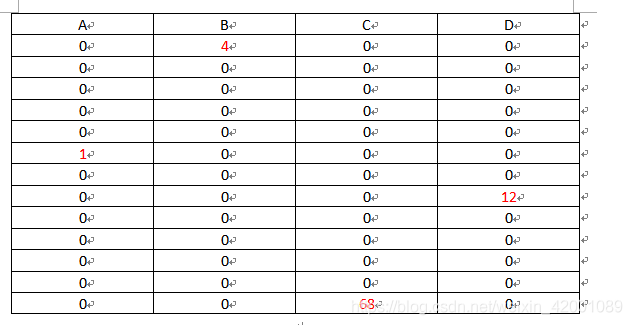

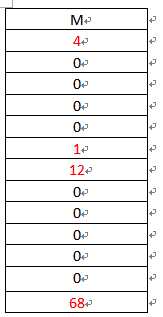
是不是感觉很眼熟，是的其逆过程即从右图到左图就是有种ont-hot的味道。

知道了何谓排斥那么第一个问题就解决了，再来看第二个问题，具体怎么合并，上面是一种比较极端的情况，一般的情况是这样：

假如A特征的范围是[0,10),B特征的范围是[0,20),那么就给B特征加一个偏值，比如10，那么B的范围就变为[10,30)，所以捆绑为一个特征后范围就是[0,30]。算法对应右图

所以结合两个问题来看其完成的任务不但是简简单单的捆绑，而且要达到捆绑后还能从取值上区分出特征之间的关系。

看了上面的理论再看左边的算法就很简单了，大概就是先计算当前特征和当前bundle冲突，冲突小就将当前特征捆绑到当前bundle中，否则就再重新建一个bundle。需要注意的是该过程只需要在最开始做一次就好了，后面就都用捆绑好的bundle，其算法复杂度显而易见是#feature*#feature，但是当特征纬度过高，这显然也是不好的，于是乎对算法进行了改进，其不再建立图了，而是统计非零的个数，非零个数越多就说明冲突越大，互相排斥越小，越不能捆绑到一起。

GetConfilctCount：这里就是计算冲突树的地方  
大体可以其就是在统计非零个数。

In [ ]:
int GetConfilctCount(const std::vector<bool>& mark, const int* indices, int num_indices, int max_cnt) {
  int ret = 0;
  for (int i = 0; i < num_indices; ++i) {
    if (mark[indices[i]]) {
      ++ret;
      if (ret > max_cnt) {
        return -1;
      }
    }
  }
  return ret;
}

FindGroups：解决上述问题一即哪些特征需要合并  
这里就看一下最关键的部分大约在105行

In [ ]:

for (auto gid : search_groups) {
      const int rest_max_cnt = max_error_cnt - group_conflict_cnt[gid];
      int cnt = GetConfilctCount(conflict_marks[gid], sample_indices[fidx], num_per_col[fidx], rest_max_cnt);
      if (cnt >= 0 && cnt <= rest_max_cnt) {
        data_size_t rest_non_zero_data = static_cast<data_size_t>(
          static_cast<double>(cur_non_zero_cnt - cnt) * num_data / total_sample_cnt);
        if (rest_non_zero_data < filter_cnt) { continue; }
        need_new_group = false;
        features_in_group[gid].push_back(fidx);
        group_conflict_cnt[gid] += cnt;
        group_non_zero_cnt[gid] += cur_non_zero_cnt - cnt;
        MarkUsed(conflict_marks[gid], sample_indices[fidx], num_per_col[fidx]);
        if (is_use_gpu) {
          group_num_bin[gid] += bin_mappers[fidx]->num_bin() + (bin_mappers[fidx]->GetDefaultBin() == 0 ? -1 : 0);
        }
        break;
      }
    }
    if (need_new_group) {
      features_in_group.emplace_back();
      features_in_group.back().push_back(fidx);
      group_conflict_cnt.push_back(0);
      conflict_marks.emplace_back(total_sample_cnt, false);
      MarkUsed(conflict_marks.back(), sample_indices[fidx], num_per_col[fidx]);
      group_non_zero_cnt.emplace_back(cur_non_zero_cnt);
      if (is_use_gpu) {
        group_num_bin.push_back(1 + bin_mappers[fidx]->num_bin() + (bin_mappers[fidx]->GetDefaultBin() == 0 ? -1 : 0));
      }
    }

其首先通过 GetConfilctCount计算冲突数，如果符合要求就将其捆绑当前的bundle即源码中features_in_group，  
并且将need_new_group设置为false意思是不用新建bundle啦，否则就新建，并且将当前feature的id捆绑当其中即代码中的：

## GOSS:
GOSS是论文提出两大技术的另一个，其算法如下：

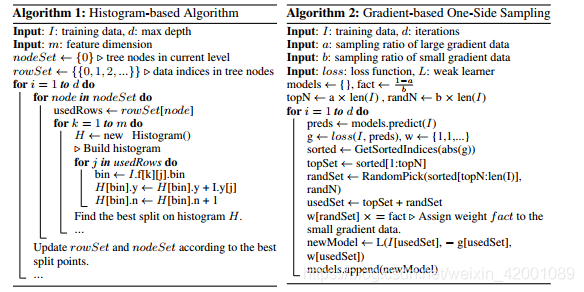

对于稀疏数据集来说：

首先GBDT如果采用pre-sorted方式进行分裂可以通过忽略掉大部分值为0特征来减少复杂度（具体怎么做有兴趣的可以看一下原论文参考文献13），但是我们说了使用histogram-based的好处多多，但是GBDT如果使用了histogram-based形式，则没有了相关的稀疏优化方法，因为histogram-based需要遍历所有的数据的bin值，而不会管其值是不是0，同时呢？我们知道传统的Adaboost其实数据集都是有一个权值的，用来衡量其重要程度，没有被好好训练的样本其权值就大，以便下一个基学习器对其多加训练，于是就可以依据该权值对其采用，这样就做到采用利用部分数据集，但是呢？我们知道在GBDT中是没有权值这一说的，其每次利用的都是整个数据集，其这些数据集的权重是一样的，所以怎么办呢？

于是乎lightGBM提出了GOSS，其是这样想的：

抽样肯定还是要抽的，毕竟减少了样本减少了复杂度嘛！没有权值我们根据什么抽呢？其发现可以将一阶导数看做权重，一阶导数大的说明离最优解还远，这部分样本带来的增益大，或者说这部分样本还没有被好好训练，下一步我们应该重点训练他们。

对应的是右图的算法，a代表对大梯度样本的采样率，b代表对小梯度样本的采样率，首先对梯度排序得到sorted，前后取前topN作为大梯度样本集合topSet（topN的个数是通过a确定的）,然后在剩下的里面随机抽取（RandomPick为随机抽取算法）randN个作为小梯度样本集合randSet,最后将两者合并作为采用后的样本usedSet，我们就拿这个样本取训练，同时呢为了尽可能不改变数据集的概率分布（因为这样抽的结果就是小梯度的样本被不断的减少再减少），所以还有给小样本一个补偿，那就是乘以一个常数即（1-a）/b，可以看到当a=0时就变成了随机采用啦，这样抽的结果还是能保持准确率的，这里有详细的数学证明，请看论文的3.2部分。

下面来看一下源码：  
其.h文件位于LightGBM/src/boosting/goss.hpp  

该类下主要有如下方法： 

Init  

ResetTrainingData  

ResetGoss  

Bagging  

BaggingHelper  

Init、ResetTrainingData、ResetGoss  
前三个方法都可以简单将其看为GOSS的一些初始化。都很简单，看一下源码就大概明白了，这里顺便简单说一下ResetGoss中的几个注意点：  

首先看如下代码：

In [ ]:
CHECK(config_->top_rate + config_->other_rate <= 1.0f);
CHECK(config_->top_rate > 0.0f && config_->other_rate > 0.0f);
    if (config_->bagging_freq > 0 && config_->bagging_fraction != 1.0f) {
      Log::Fatal("Cannot use bagging in GOSS");
    }
    Log::Info("Using GOSS");

这里的的top_rate和other_rate就是我们上面理论部分说的a,b，正如代码看到的两则都必须大于0且和小于1，否则就不能用GOSS，同时还会发现，  
当bagging_freq大于0且bagging_fraction不等于1时也是不能用GOSS的，对应可以到官方API参数描述上查询

## Leaf-wise
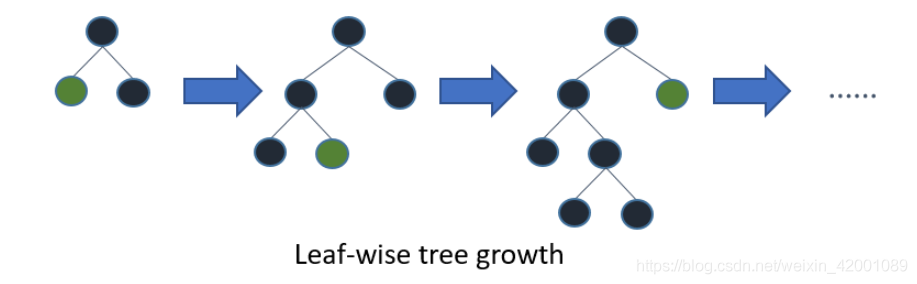

Level-wise是将同一层所有的叶子节点进行分裂，这也是以前GBDT各种演变算法所采用的策略，而LightGBM采用的Leaf-wise是每次选取最大增益的那个叶子节点进行分类，可以看到生长相同的leaf时，leaf-wise 算法可以比 level-wise 算法减少更多的损失即得到更大的增益，但是其缺点就是可能会长出比较深的决策树，产生过拟合。因此LightGBM在Leaf-wise之上增加了一个最大深度限制，在保证高效率的同时防止过拟合。

## 模型优化

方法1：  
SVM、RandomForest、XGBoost、LightGBM、Catboost共同训练  
1.一个错分样本，部分模型预测正确，部分模型预测错误：可能由模型或参数导致；  
2.一个错分样本，全部模型预测错误：可能是样本本身问题，可以用模型解释工具分析错分样本特征，判断该样本是否可以删除

方法2：  
可参考深度学习中的hard sample方法  
剔除部分easy样本：所有模型都预测正确，且预测概率极大或极小的样本；easy样本容易区分，对模型学习没有太大帮助；  
hard sample可以使得模型学习更加充分，当未来遇到复杂变化的样本时，预测能力更强，更鲁棒

https://zhuanlan.zhihu.com/p/58162337